In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import sys
import lmfit
from scipy import special
import function as func
import fit_script as fit

In [2]:
# Constants
v_c = 220.e+3 # [m/sec] speed of solar system
v_E = v_c # [m/sec] speed of earth
c = 299792458. # [m/sec] speed of light from wikipedia
k_B = 1.380649e-23 # [J/K] boltzmann constant
rbw = 3.e+2 # [Hz]
binwidth = 2.e+3 # [Hz]
T_LN2 = 77 # [K]

In [3]:
def cummulative_velocity(v):
    C = v_c/(2.*np.sqrt(np.pi)*v_E) 
    exp_p = np.exp( -1. * np.power((v+v_E)/v_c, 2.) )
    exp_m = np.exp( -1. * np.power((v-v_E)/v_c, 2.) )
    erf_p = special.erf((v+v_E)/v_c)
    erf_m = special.erf((v-v_E)/v_c)

    f = C*(exp_p-exp_m) + 1./2. * (erf_p + erf_m)
    return f

def freq_to_velocity(freq, freq_0):
    ok = (freq>freq_0)
    v  = np.full(len(freq), 0.)
    v[ok] = c * np.sqrt( 1. - np.power(freq_0/freq[ok], 2.))
    return v

def integral_binwidth_velocity(freq, freq_0, binwidth):
    v_p = freq_to_velocity(freq+binwidth/2., freq_0)
    v_m = freq_to_velocity(freq-binwidth/2., freq_0)
    integral = cummulative_velocity(v_p) - cummulative_velocity(v_m)
    return integral

def fit_func(freq, a, b, P, freq_0):
    integral = integral_binwidth_velocity(freq, freq_0, binwidth)
    peak = P * integral
    power = peak + a*(freq-freq_0) + b
    return power

def signal(freq, P, freq_0):
    integral = integral_binwidth_velocity(freq, freq_0, binwidth)
    peak = P * integral
    return peak

def residual(params, fit_freq, fit_Psig, yerr, freq_0):
    a = params['a']
    b = params['b']
    P = params['P']
    y_model = fit_func(fit_freq, a, b, P, freq_0)
    chi = (fit_Psig - y_model)/yerr
    o = np.isfinite(chi)
    return chi[o]

5.10585778049366e-18


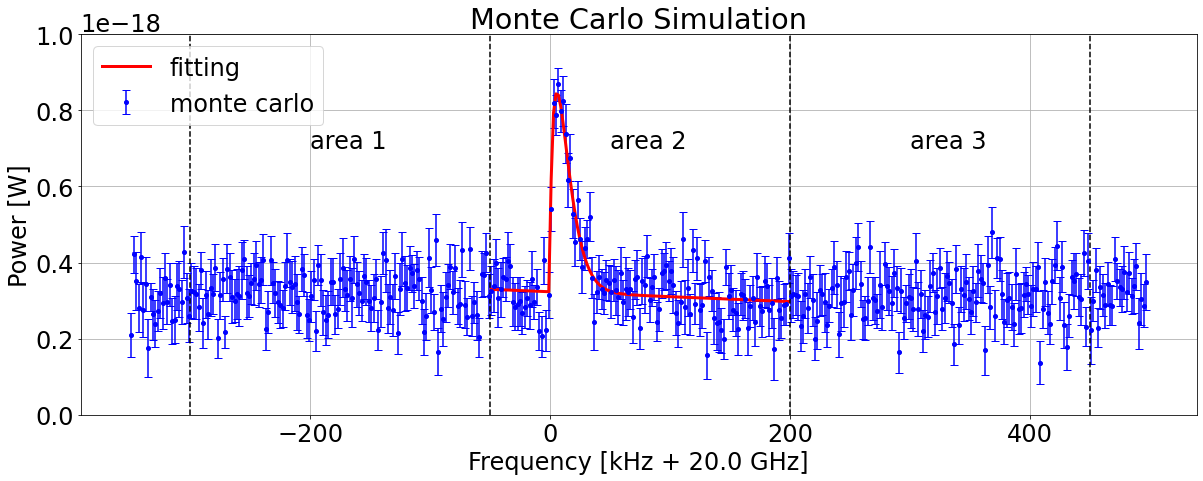

In [60]:
x = np.arange(20e+9 - 350e+3, 20e+9 + 500e+3,76)

T_plate = 77 # [K]
plate = k_B * T_plate * rbw
noise = np.random.normal(loc=plate, scale=plate, size=len(x))
_d, _n, _n_err = func.rebin_func(x, noise)

chi = 8.e-10
Aeff = 1.5e-3 # [m^2]
P = (chi/1.4e-10)**2 * 1e-19 * (Aeff/1e-3)
freq_0 = 20.0e+9

_f, _W, _err = func.rebin_func(x, signal(x, P, freq_0))

x = (_f - 20.0e+9)/1e+3
y = _W + _n
err = (_err**2 + _n_err**2)**0.5


# fitting

params = lmfit.Parameters()
params.add('a', value=1.)
params.add('b', value=1.)
params.add('P', value=1.)

fit_freq = []
fit_Psig = []
fit_left = []
fit_right = []
for _f, _s in zip(_f, y):
    if _f >= freq_0 - 50.e+3 and _f <= freq_0 + 200.e+3:
        fit_freq.append(_f)
        fit_Psig.append(_s)
    if _f >= freq_0 - 250.e+3 and _f <= freq_0 - 150.e+3:
        fit_left.append(_s)
    if _f >= freq_0 + 150.e+3 and _f <= freq_0 + 250.e+3:
        fit_right.append(_s)

fit_freq = np.array(fit_freq)
fit_Psig = np.array(fit_Psig)
Perr = (np.std(np.array(fit_left)) + np.std(np.array(fit_right)))/2

result = lmfit.minimize(residual, params, args=(fit_freq, fit_Psig, Perr, freq_0))
_a = result.params["a"].value
_b = result.params["b"].value
_P = result.params["P"].value

print(_P)

plt.figure(figsize=(20,7))
plt.rcParams["font.size"] = 24

aa = 100
bb = -100
plt.errorbar(x, y, yerr = err, capsize=4, fmt='o', markersize=4, label="monte carlo", color="blue", alpha=1)
plt.plot((fit_freq - freq_0)/1e+3, fit_func(fit_freq, _a, _b, _P, freq_0), color="red", label="fitting", linewidth = 3)

plt.axvline(x = -300, color="black", linestyle='--')
plt.axvline(x = -50, color="black", linestyle='--')
plt.axvline(x = 200, color="black", linestyle='--')
plt.axvline(x = 450, color="black", linestyle='--')

plt.text(-200, 7e-19, "area 1", fontsize=24)
plt.text(50, 7e-19, "area 2", fontsize=24)
plt.text(300, 7e-19, "area 3", fontsize=24)

plt.xlabel("Frequency [kHz + 20.0 GHz]")
plt.ylabel("Power [W]")
plt.title("Monte Carlo Simulation")
plt.grid()
plt.legend(loc="upper left")
plt.ylim([0, 1e-18])
#plt.xlim([-110, 260])
plt.savefig("../result_figure/montecarlo_signal4.pdf")


4.689384918168419e-17


(0.0, 1e-17)

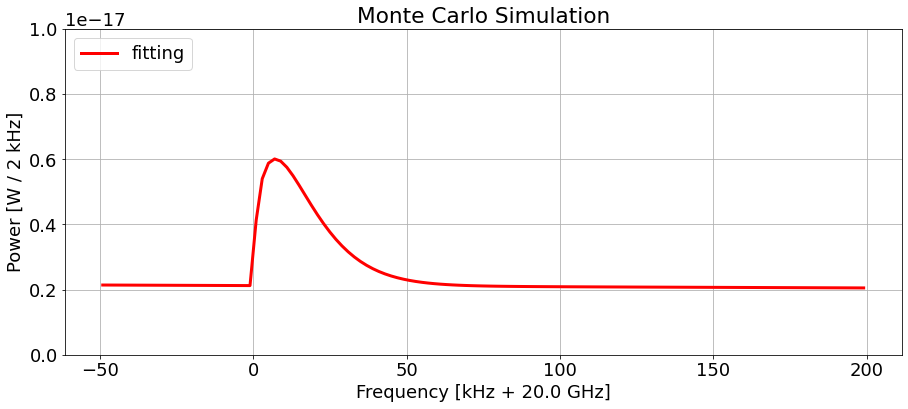

In [35]:
x = np.arange(20e+9 - 350e+3, 20e+9 + 500e+3,76)

plate = k_B * 77 * 2e+3
noise = np.random.normal(loc=plate, scale=plate, size=len(x))
_d, _n, _n_err = func.rebin_func(x, noise)

chi = 8.e-11
Aeff = 1.5e-3 # [m^2]
P = 1.e-19 * chi**2 * Aeff / (1.4e-13)**2
freq_0 = 20.0e+9

_f, _W, _err = func.rebin_func(x, signal(x, P, freq_0))

x = (_f - 20.0e+9)/1e+3
y = _W + _n
err = (_err**2 + _n_err**2)**0.5


# fitting

params = lmfit.Parameters()
params.add('a', value=1.)
params.add('b', value=1.)
params.add('P', value=1.)

fit_freq = []
fit_Psig = []
fit_left = []
fit_right = []
for _f, _s in zip(_f, y):
    if _f >= freq_0 - 50.e+3 and _f <= freq_0 + 200.e+3:
        fit_freq.append(_f)
        fit_Psig.append(_s)
    if _f >= freq_0 - 250.e+3 and _f <= freq_0 - 150.e+3:
        fit_left.append(_s)
    if _f >= freq_0 + 150.e+3 and _f <= freq_0 + 250.e+3:
        fit_right.append(_s)

fit_freq = np.array(fit_freq)
fit_Psig = np.array(fit_Psig)
Perr = (np.std(np.array(fit_left)) + np.std(np.array(fit_right)))/2

result = lmfit.minimize(residual, params, args=(fit_freq, fit_Psig, Perr, freq_0))
_a = result.params["a"].value
_b = result.params["b"].value
_P = result.params["P"].value

print(_P)

plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 18

#plt.errorbar(x, y, yerr = err, capsize=4, fmt='o', markersize=4, label="monte carlo", color="blue", alpha=1)
plt.plot((fit_freq - freq_0)/1e+3, fit_func(fit_freq, _a, _b, _P, freq_0), color="red", label="fitting", linewidth = 3)

#plt.axvline(x = -300, color="black", linestyle='--')
#plt.axvline(x = -50, color="black", linestyle='--')
#plt.axvline(x = 200, color="black", linestyle='--')
#plt.axvline(x = 450, color="black", linestyle='--')

#plt.text(-200, 5e-18, "area 1", fontsize=20)
#plt.text(50, 5e-18, "area 2", fontsize=20)
#plt.text(300, 5e-18, "area 3", fontsize=20)

plt.xlabel("Frequency [kHz + 20.0 GHz]")
plt.ylabel("Power [W / 2 kHz]")
plt.title("Monte Carlo Simulation")
plt.grid()
plt.legend(loc="upper left")
plt.ylim([0, 1e-17])
#plt.savefig("../result_figure/montecarlo_signal.pdf")